In [3]:
#GET DATA
import os
import pandas as pd

categories = ["blues", "classical-music", "country", "electronic", "experimental", "folk", "jazz", "pop", "r-b", "rap", "rock"]
#initialize lists of data
lyrics = []
primary_tags = []
for category in categories:
    directory_path = "../../data/lyrics/"+category
    directory = os.fsencode(directory_path)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        full_path = os.path.join(directory_path, str(filename))
        if os.path.exists(full_path):
            with open(full_path, 'r', encoding='cp850') as src:
                lyric = src.read()
            lyrics.append(lyric)
            primary_tags.append(category)


df = pd.DataFrame({"lyric": lyrics, "category":primary_tags})
df.head()

,lyric,category
0,"And you got me like, oh\nWhat you want from me...",blues
1,There is a house in New Orleans\nThey call the...,blues
2,"Her eyes and words are so icy\nOh, but she bur...",blues
3,"Waking up, half-past five\nBlood on pillow and...",blues
4,And the tennis court was covered up\nWith some...,blues


In [6]:
#DATA CLEANING
import re

#remove punctuation
df['lyric_processed'] = \
df['lyric'].map(lambda x: re.sub('[,\.!?]', '', x))
#make lowercase
df['lyric_processed'] = \
df['lyric'].map(lambda x: x.lower())
df.head()

,lyric,category,lyric_processed
0,"And you got me like, oh\nWhat you want from me...",blues,"and you got me like, oh\nwhat you want from me..."
1,There is a house in New Orleans\nThey call the...,blues,there is a house in new orleans\nthey call the...
2,"Her eyes and words are so icy\nOh, but she bur...",blues,"her eyes and words are so icy\noh, but she bur..."
3,"Waking up, half-past five\nBlood on pillow and...",blues,"waking up, half-past five\nblood on pillow and..."
4,And the tennis court was covered up\nWith some...,blues,and the tennis court was covered up\nwith some...


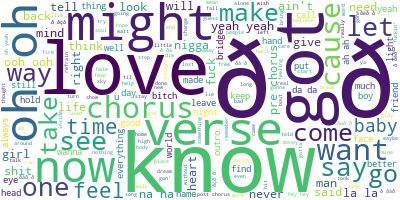

In [9]:
#WORDCLOUD AS EXTRAPOLARYY DATA ANALYSIS
from wordcloud import WordCloud

long_string = ','.join(list(df['lyric_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [10]:
'''
Things to do:
1.) Whats the sigma meaning and why is it there two times
2.) Need to filter out chorus, verse, 
3.) Do I want stuff like oh oh or la la or na na or da da, and how would I filter it without taking out a single Oh 
'''

and you got me like, oh
what you want from me? (what you want from me?)
and i tried to buy your pret
